/var/folders/tx/j83wm_md7rb0sm_4t85m_dfc0000gn/T/ipykernel_50979/2447718931.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'Close'] = df['Close']



Model Performance Metrics with Forward Validation:
R-squared Score: 0.9933
Root Mean Square Error (RMSE): 87.2056
Mean Absolute Error: 38.6347
Mean Prediction Accuracy: 98.07%


/Users/danielharapiak/myenv/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


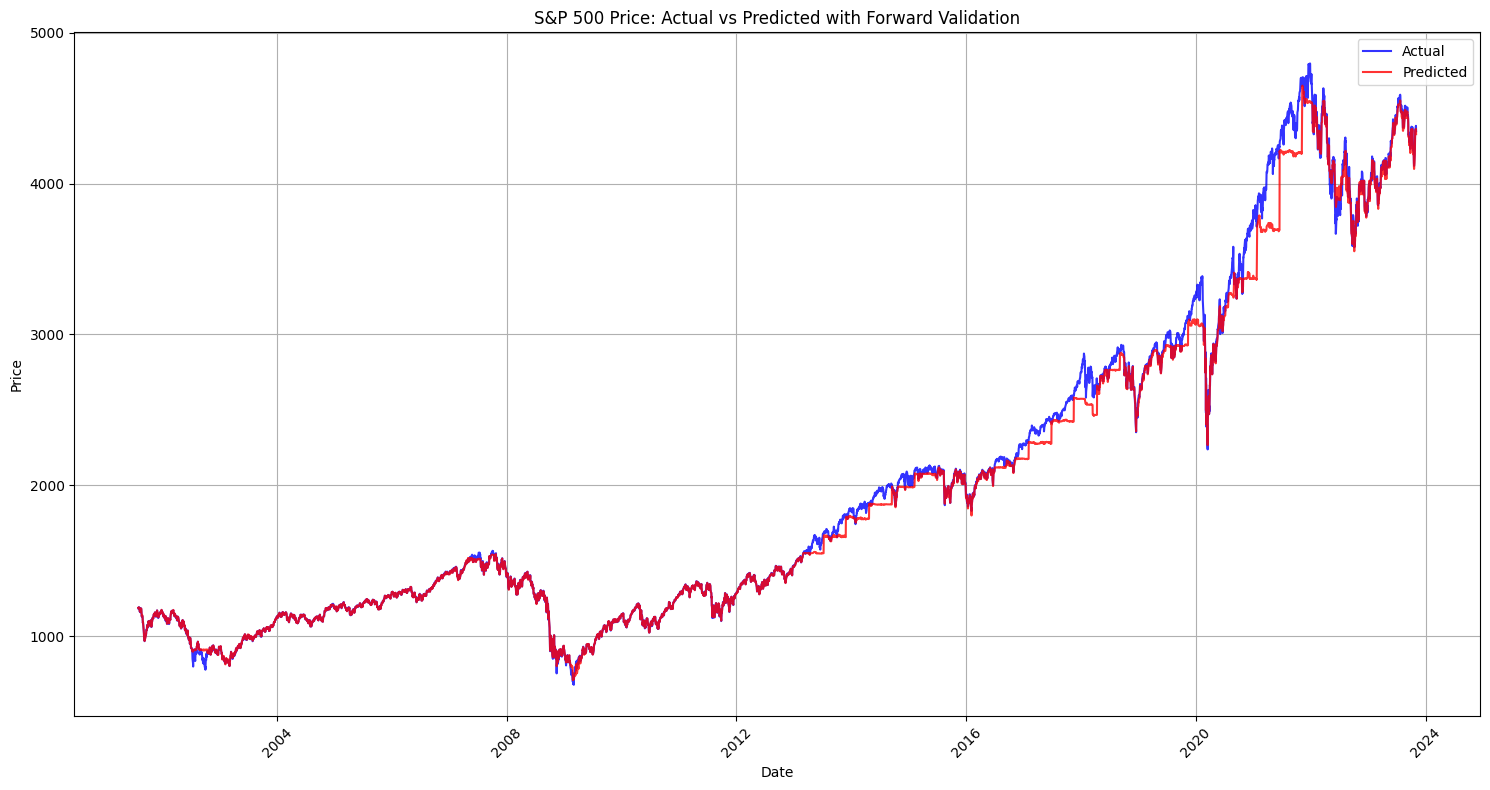

In [27]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Helper functions
def ATR(DF, n=14):
    df = DF.copy()
    df["H-L"] = df["High"] - df["Low"]
    df["H-PC"] = abs(df["High"] - df["Adj Close"].shift(1))
    df["L-PC"] = abs(df["Low"] - df["Adj Close"].shift(1))
    df["TR"] = df[["H-L", "H-PC", "L-PC"]].max(axis=1, skipna=False)
    df["ATR"] = df["TR"].ewm(com=n, min_periods=n).mean()
    return df["ATR"]

def RSI(DF, n=14):
    df = DF.copy()
    df["change"] = df["Adj Close"] - df["Adj Close"].shift(1)
    df["gain"] = np.where(df["change"] >= 0, df["change"], 0)
    df["loss"] = np.where(df["change"] < 0, -1 * df["change"], 0)
    df["avgGain"] = df["gain"].ewm(alpha=1/n, min_periods=n).mean()
    df["avgLoss"] = df["loss"].ewm(alpha=1/n, min_periods=n).mean()
    df["rs"] = df["avgGain"] / df["avgLoss"]
    df["rsi"] = 100 - (100 / (1 + df["rs"]))
    return df["rsi"]

def MACD(DF, a=12, b=26, c=9):
    df = DF.copy()
    df["ma_fast"] = df["Adj Close"].ewm(span=a, min_periods=a).mean()
    df["ma_slow"] = df["Adj Close"].ewm(span=b, min_periods=b).mean()
    df["macd"] = df["ma_fast"] - df["ma_slow"]
    df["signal"] = df["macd"].ewm(span=c, min_periods=c).mean()
    return df[["macd", "signal"]]

def max_dd(DF):
    df = DF.copy()
    df["return"] = df["Adj Close"].pct_change()
    df["cum_return"] = (1 + df["return"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    return (df["drawdown"] / df["cum_roll_max"]).max()

def volatility(DF):
    df = DF.copy()
    df["daily_ret"] = DF["Adj Close"].pct_change()
    vol = df["daily_ret"].std() * np.sqrt(252)
    return vol

# Load the dataset
df = pd.read_csv('SP500_with_indicators_^GSPC.csv').dropna()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Features and target
features = df.columns.drop(['Close', 'Adj Close'])
target = 'Close'

X = df[features]
y = df[target]

# Include 'Close' in the features for lag calculation
X.loc[:, 'Close'] = df['Close']

# Normalize the features
X_numeric = X.select_dtypes(include=[np.number])
X_numeric = X_numeric.dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_numeric.columns, index=X_numeric.index)

# Add lag features
for lag in range(1, 6):
    X_scaled_df[f'lag_{lag}'] = X_scaled_df['Close'].shift(lag)

# Drop rows with NaN values created by lag features
X_scaled_df.dropna(inplace=True)
y = y.loc[X_scaled_df.index]

# Forward validation function
def forward_validation(df, initial_train_size, step_size, model_params):
    predictions = []
    actuals = []
    dates = []
    n_splits = (len(df) - initial_train_size) // step_size

    for i in range(n_splits):
        train_start = 0
        train_end = initial_train_size + i * step_size
        test_start = train_end
        test_end = test_start + step_size

        X_train, y_train = X_scaled_df.iloc[train_start:train_end], y.iloc[train_start:train_end]
        X_test, y_test = X_scaled_df.iloc[test_start:test_end], y.iloc[test_start:test_end]
        dates.extend(df.index[test_start:test_end])

        # Train the model
        model = xgb.XGBRegressor(**model_params)
        model.fit(X_train, y_train)

        # Predict on the test set
        preds = model.predict(X_test)
        predictions.extend(preds)
        actuals.extend(y_test)

    return predictions, actuals, dates, model

# Define forward validation parameters
initial_train_size = 1000
step_size = 100
model_params = {
    "n_estimators": 500,
    "learning_rate": 0.01,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "random_state": 42
}

# Perform forward validation
predictions, actuals, dates, model = forward_validation(df, initial_train_size, step_size, model_params)

# Calculate performance metrics
test_rmse = mean_squared_error(actuals, predictions, squared=False)
test_r2 = r2_score(actuals, predictions)
test_mae = mean_absolute_error(actuals, predictions)
mean_prediction_accuracy = 100 * (1 - test_mae / np.mean(actuals))

print("\nModel Performance Metrics with Forward Validation:")
print(f"R-squared Score: {test_r2:.4f}")
print(f"Root Mean Square Error (RMSE): {test_rmse:.4f}")
print(f"Mean Absolute Error: {test_mae:.4f}")
print(f"Mean Prediction Accuracy: {mean_prediction_accuracy:.2f}%")

# Plot actual vs predicted values
plt.figure(figsize=(15, 8))
plt.plot(dates, actuals, label='Actual', color='blue', alpha=0.8)
plt.plot(dates, predictions, label='Predicted', color='red', alpha=0.8)
plt.title('S&P 500 Price: Actual vs Predicted with Forward Validation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()